In [89]:
print(__doc__)
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from sklearn.utils import check_random_state
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import mutual_info_score

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# from ace import model
# from ace import ace
import ace.model
import ace.ace

pd.options.display.float_format = "{:.1f}".format

 Formulas

Mutual Information: MI(B,Y') = \sum_{i = 1}^{|B|}\sum_{j = 1}^{|Y'|}rac{|B_{i} \cap Y'_{j}|}{N} lograc{N|B_{i} \cap Y'_{j}|}{|B_{i}||Y'_{j}|}
Statistical Parity: SP(B,Y') = |P(Y' = 1|B = a) - P(Y' = 1|B = b)| \quad orall a,b \in B
Equal Opportunity: EOP(B,Y') = |P(Y' = 1|B = a, Y = 1) - P(Y' = 1|B = b, Y = 1)| \quad orall a,b \in B
Equalized Odds: EOD(B,Y') = |P(Y' = 1|B = a, Y = y) - P(Y' = 1|B = b, Y = y)| \quad orall a,b \in B, \quad orall 0,1 \in y
Conditional Use Accuracy Equality: CUAE(B,Y') = |P(Y' = y|B = a, Y = y) - P(Y' = y|B = b, Y = y)| \quad orall a,b \in B, \quad orall 0,1 \in y
Disparate Impact: DI(B,Y') = |P(Y' = 1|B = a) / P(Y' = 1|B = b)| \quad orall a,b \in B

Source
----------

separation \ Equal opportunity - Hardt, Price, Srebro (2016)
separation \ Equalized adds - Hardt, Price, Srebro (2016)
independence \ Mutual information - Cover, T.M.; Thomas, J.A. (1991). Elements of Information Theory (Wiley ed.)
sufficiency \ Conditional Use Accuracy Eq

In [90]:
def retrieve_data_recid():

    """ This function is used for retrieving dataset COMPAS and split data entries into labeled (training, testing) and unlabeled data (validation) 
    Prediction task is to determine whether a person will recidive after first prosecution"""

    """ Binary classification
    =================  ======================
    samples total      5875
    Dimensionality     9(Features)+1(Bias)
    Features           real
    Classes            2
    =================  ======================

    Source
    ----------
    How We Analyzed the COMPAS Recidivism Algorithm, by Jeff Larson, Surya Mattu, Lauren Kirchner and Julia Angwin, May 23, 2016
    https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
    https://github.com/propublica/compas-analysis
    
    Parameters
    ----------
    none

    Returns
    -------
    X_labeled: training data, ndarray, shape (10, 9)
    y_labeled: training target, ndarray, shape (10, ) 
    b_labeled: bias attribute of training set, ndarray, shape (10, )

    X_unlabeled: sample pool data, ndarray, shape (4397, 9)
    y_unlabeled: sample pool target, ndarray, shape (4397, )
    b_unlabeled: bias attribute of sample pool set, ndarray, shape (4397, )

    X_test: testing data, ndarray, shape (1468, 9)
    y_test: testing target, ndarray, shape (1468, )
    b_test: bias attribute of testing set, ndarray, shape (1468, )
    """
    
    # mc_attributes = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree','race']
    attributes = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree']
    bias = 'race'
    target = 'two_year_recid'

    # np.random.seed(42)
    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/RecidivismData_Normalized.csv", sep=',')
    data_col = data.columns
    df = data[(data[bias]==2)|(data[bias]==3)].copy().values
    # print(df.shape)

    b_Xb_data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/b_Xb_Mc.csv", sep=',').values
    X_Xb_data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/X_Xb_Mc.csv", sep=',').values
    y_Xy_data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/y_Xy_Mc.csv", sep=',').values
    X_Xy_data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/X_Xy_Mc.csv", sep=',').values

    # print(b_Xb_data.shape, X_Xb_data.shape, y_Xy_data.shape, X_Xy_data.shape)

    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(df):
        train, test = df[train_index], df[test_index]
        X_Xb_train, X_Xb_test = X_Xb_data[train_index], X_Xb_data[test_index]
        b_Xb_train, b_Xb_test = b_Xb_data[train_index], b_Xb_data[test_index]
        X_Xy_train, X_Xy_test = X_Xy_data[train_index], X_Xy_data[test_index]
        y_Xy_train, y_Xy_test = y_Xy_data[train_index], y_Xy_data[test_index]
        # print("Size of X_train, X_test:", train.shape, test.shape, X_Xb_train.shape, X_Xb_test.shape, b_Xb_train.shape, b_Xb_test.shape, X_Xy_train.shape, X_Xy_test.shape, y_Xy_train.shape, y_Xy_test.shape)

    df_train = pd.DataFrame(data=train, columns=data_col)
    df_test = pd.DataFrame(data=test, columns=data_col)

    X_Xb_train_df = pd.DataFrame(data=X_Xb_train, columns=attributes)
    X_Xb_test_df = pd.DataFrame(data=X_Xb_test, columns=attributes)
    b_Xb_train_df = pd.DataFrame(data=b_Xb_train, columns=[bias])
    b_Xb_test_df = pd.DataFrame(data=b_Xb_test, columns=[bias])
    X_Xy_train_df = pd.DataFrame(data=X_Xy_train, columns=attributes)
    X_Xy_test_df = pd.DataFrame(data=X_Xy_test, columns=attributes)
    y_Xy_train_df = pd.DataFrame(data=y_Xy_train, columns=[target])
    y_Xy_test_df = pd.DataFrame(data=y_Xy_test, columns=[target])
    # print("X_Xb_train:", X_Xb_train_df.columns)

    labeled = df_train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=5)) # ten sample in total labeled initially
    # labeled = df_train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=5, random_state=42)) # with a random state for stable output
    df_X_labeled = labeled[attributes]
    df_y_labeled = labeled[target]
    X_labeled = df_X_labeled.values
    y_labeled = df_y_labeled.values.astype('int64')
    b_labeled = labeled[bias].values-2 # degrade bias into binary options
    (row_size, col_size) = X_labeled.shape 
    # print(X_labeled.shape)

    unlabeled = df_train.drop(df_X_labeled.index)
    df_X_unlabeled = unlabeled[attributes]
    df_y_unlabeled = unlabeled[target]
    X_unlabeled = df_X_unlabeled.values
    y_unlabeled = df_y_unlabeled.values.astype('int64')
    b_unlabeled = unlabeled[bias].values-2
    # print(X_unlabeled.shape)

    # X_unlabeled_Xb_Mc = 

    X_unlabeled_Xb_Mc = X_Xb_train_df.drop(df_X_labeled.index).values
    b_unlabeled_Xb_Mc = b_Xb_train_df.drop(df_X_labeled.index).values
    X_unlabeled_Xy_Mc = X_Xy_train_df.drop(df_X_labeled.index).values
    y_unlabeled_Xy_Mc = y_Xy_train_df.drop(df_X_labeled.index).values.astype('int64')

    # print("Final output shape for MC:", X_unlabeled.shape, X_Xb_unlabeled.shape, b_Xb_unlabeled.shape, X_Xy_unlabeled.shape, y_Xy_unlabeled.shape)

    X_test = df_test[attributes].values
    y_test = df_test[target].values
    y_test=y_test.astype('int')
    b_test = df_test[bias].values-2
    # print(X_test.shape)
    
    return (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc, X_unlabeled_Xy_Mc, y_unlabeled_Xy_Mc, X_test, y_test, b_test)

In [91]:
class BaseModel(object):

    def __init__(self):
        pass
    def fit_predict(self):
        pass

class LogModel(BaseModel):

    def fit_predict(self, X_labeled, y_labeled, X_test, y_test):
        self.classifier = LogisticRegression(
            solver='liblinear'
            )
        self.classifier.fit(X_labeled, y_labeled)
        features_weight= self.classifier.coef_.T
        # self.y_test_predicted = self.classifier.predict(X_test)
        # self.y_unlabeled_predicted = self.classifier.predict(X_unlabeled)
        self.y_test_score = self.classifier.score(X_test, y_test)
        return (X_labeled, X_test, self.y_test_score, features_weight)

In [92]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    def train(self, X_labeled, y_labeled, X_test, y_test):
        (X_labeled, X_test, self.y_test_score, features_weight) = \
            self.model_object.fit_predict(X_labeled, y_labeled, X_test, y_test)
        return (X_labeled, X_test, features_weight)

    def get_test_accuracy(self, i):
        classif_rate = self.y_test_score * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        # print("Accuracy rate is %f " % (classif_rate))

In [93]:
def random_selection(probas_val, step):
    # random_state = check_random_state(63)
    selection = np.random.choice(probas_val.shape[0], step, replace=False)
    return selection

# def entropy_selection(probas_val, step):
#     e = (-probas_val * np.log2(probas_val)).sum(axis=1)
#     selection = (np.argsort(e)[::-1])[:step]
#     return selection

In [94]:
def normalizer(e_loss, f_loss):
    e_loss = np.reshape(e_loss, (1,len(e_loss)))
    f_loss = np.reshape(f_loss, (1,len(f_loss)))
    e_scaled = preprocessing.normalize(e_loss)
    # e_scaled=((e_loss-e_loss.min())/(e_loss.max()-e_loss.min()))
    f_scaled = preprocessing.normalize(f_loss)
    # f_scaled=((f_loss-f_loss.min())/(f_loss.max()-f_loss.min()))
    e_scaled = e_scaled.flatten()
    f_scaled = f_scaled.flatten()
    return (e_scaled, f_scaled)

In [95]:
def log_loss(probas_val):
    
    eps = np.finfo(probas_val.dtype).eps
    probas_val = np.clip(probas_val, eps, 1 - eps)
    e_loss = (-probas_val * np.log2(probas_val)).sum(axis=1)

    return e_loss

In [96]:
""" This function is used for calculating fairness loss, aka the unfairness of a logistic regression model. The fairness measurement is used to provide loss values that helps determine the fluctuation of unfairness change with each iteration that adds samples to the labeled dataset. There are many different methods for unfairness measurement, however, five different meausures are coded and only one of them will be used for unfairness measurement in the correlation-based sampling. """

""" Formulas

Mutual Information: MI(B,Y') = \sum_{i = 1}^{|B|}\sum_{j = 1}^{|Y'|}\frac{|B_{i} \cap Y'_{j}|}{N} log\frac{N|B_{i} \cap Y'_{j}|}{|B_{i}||Y'_{j}|}
Statistical Parity: SP(B,Y') = |P(Y' = 1|B = a) - P(Y' = 1|B = b)| \quad \forall a,b \in B
Equal Opportunity: EOP(B,Y') = |P(Y' = 1|B = a, Y = 1) - P(Y' = 1|B = b, Y = 1)| \quad \forall a,b \in B
Equalized Odds: EOD(B,Y') = |P(Y' = 1|B = a, Y = y) - P(Y' = 1|B = b, Y = y)| \quad \forall a,b \in B, \quad \forall 0,1 \in y
Conditional Use Accuracy Equality: CUAE(B,Y') = |P(Y' = y|B = a, Y = y) - P(Y' = y|B = b, Y = y)| \quad \forall a,b \in B, \quad \forall 0,1 \in y
Disparate Impact: DI(B,Y') = |P(Y' = 1|B = a) / P(Y' = 1|B = b)| \quad \forall a,b \in B

Source
----------

separation \ Equal opportunity - Hardt, Price, Srebro (2016)
separation \ Equalized adds - Hardt, Price, Srebro (2016)
independence \ Mutual information - Cover, T.M.; Thomas, J.A. (1991). Elements of Information Theory (Wiley ed.)
sufficiency \ Conditional Use Accuracy Equality - Richard Berk et al., (2017) Fairness in Criminal Justice Risk Assessments: The State of the Art

Parameters
----------
X_fair_est: testing data, ndarray
y_fair_est: testing target, ndarray
b_fair_est: bias attribute of testing set, ndarray

Returns
-------
f_loss: fairness loss, int
"""

def mut_inf(X_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    f_loss=mutual_info_score(b_fair_est, y_fair_pred)
    f_loss=abs(f_loss)
    
    return f_loss

# selecting fairness criteria
def fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=None, criteria=0):
    if criteria == 'mutual_information':
        return mut_inf(X_fair_est, b_fair_est, classifier)
    # elif criteria == 'equal_opportunity':
    #     return eqops(X_fair_est, y_fair_est, b_fair_est, classifier)
    # elif criteria == 'statistical_parity':
    #     return stats_parity(X_fair_est, b_fair_est, classifier)
    # elif criteria == 'equalized_odds':
    #     return eqods(X_fair_est, y_fair_est, b_fair_est, classifier)
    # elif criteria == "disparate_impact":
    #     return disp_impt(X_fair_est, b_fair_est, classifier)
    # elif criteria == "conditional_use_accuracy_equality":
    #     return cuae(X_fair_est, y_fair_est, b_fair_est, classifier)

In [97]:
def fair_loss_corr(X_data, prob_expected, row_size, y_labeled_sum, yhatb_corr, Xy_labeled_sum, X_labeled_sum, features_weight, Xb_corr, Xy_corr, Xy_std):

    # print("Correlation between X and S:", Xb_corr)
    # print("Correlation between y' and S:", yhatb_corr)
    # print("d:prob_expected:", prob_expected.shape, prob_expected) output: shape(2,1), probabilities of y' =0 and 1

    fair_loss = 0
    fair_improvement = 0
    row_expected = row_size + 1 
    for i in range(len(prob_expected)): 
        y_expected = (y_labeled_sum + i)/row_expected
        Xy_expected = np.add(Xy_labeled_sum , X_data*i)/row_expected
        X_expected = np.add(X_labeled_sum , X_data)/row_expected
        Xy_corr_expected = (np.subtract(Xy_expected, (X_expected * y_expected)))/Xy_std
        # print("Correlation between X and y:", Xy_corr)
        # print("Expected correlation between X and y:", Xy_corr_expected)
        fair_improvement = np.dot((abs(features_weight*Xb_corr)).transpose(),(abs(Xy_corr)-abs(Xy_corr_expected)).reshape(Xy_corr_expected.shape[0],1))[0,0] # if expected corr(xy) is reduced, the feature weight is higher
        fair_loss += prob_expected[i]*fair_improvement # fairness improvement for a point, both y=1 and y=0 are added as one
        # print("Shape of fair_improvement and temp[i]",fair_improvement, prob_expected[i])
    return fair_loss

In [98]:
def unfairness_correlation_sampling(X_unlabeled, classifier, probas_val, step, row_size, y_labeled_sum, yhatb_corr, Xy_labeled_sum, X_labeled_sum, features_weight, Xb_corr, Xy_corr, div, Xy_std):
    # further to be defined, now assume only fairness loss
    # query size used here

    unlabeled_size = len(X_unlabeled)
    f_loss = np.zeros(unlabeled_size)
    
    for j in range(unlabeled_size): 
            proba_temp = classifier.predict_proba(X_unlabeled[j].reshape(1, -1)).reshape(-1,1)
            # first reshape integrate as single entry
            # second reshape transpose as vertical 2D array
            f_loss[j] = fair_loss_corr(X_unlabeled[j],proba_temp, row_size, y_labeled_sum, yhatb_corr, Xy_labeled_sum, X_labeled_sum, features_weight, Xb_corr, Xy_corr, Xy_std)

    e_loss = log_loss(probas_val)

#     print("Debug f_loss before:", f_loss.shape, f_loss)

    e_scaled, f_scaled = normalizer(e_loss, f_loss)
    f_scaled[np.isnan(f_scaled)] = 0

#     print("Debug f_loss after:", f_scaled.shape, f_scaled)

    loss = div*(e_scaled)+(1-div)*f_scaled
    selection = np.argsort(loss)[::-1][:step]
    

    return selection

In [99]:
def pre_filter(X_data, b_data, y_data, budget): 

    temp_columns = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree','race','two_year_recid']
    # np.random.seed(84)

    # print("Debug data:", X_data.shape, b_data.shape, y_data.shape)
    temp_data = np.c_[X_data, b_data, y_data]
    temp_df = pd.DataFrame(data=temp_data, columns=temp_columns)
    candidates_data = temp_df.groupby('race', group_keys=False).apply(lambda x: x.sample(n=math.ceil(budget/2)))
    # candidates_data = temp_df.groupby('race', group_keys=False).apply(lambda x: x.sample(n=math.ceil(budget/2), random_state = 84))
    # print("Debug ceil:", math.ceil(budget/2))
    # print("Debug ceil:", math.ceil(budget/2))
    # print("Debug cand:", candidates)
    candidates_index = candidates_data.index.values
    # print("Debug index:", candidates_index.shape, candidates_index)

    return candidates_index

In [100]:
# def metrics(X_test, y_test, b_test, classifier):
    # y_test_pred = classifier.predict(X_test)
    # print("Classification report for classifier %s:\n%s\n" % (classifier, classification_report(y_test, y_test_pred)))
    # print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_test_pred))

    # tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    # tpr = tp/(tp+fn)
    # tnr = tn/(tn+fp) 
    # fpr = fp/(fp+tn)
    # fnr = fn/(tp+fn)
    # fdr = fp/(tp+fp)

    # fig, ax = plt.subplots()

    # model_displays = {}
    # for i in np.unique(y_test):
    #     model_displays[i] = plot_roc_curve(
    #         classifier, X_test[b_test==i], y_test[b_test==i], ax=ax, name=i)
    # ax.set_title('ROC curve')
    # plt.show() 

In [101]:

def boxplot(x, y, ax, theme = 'b', whis = 1.5):

    xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
    ylimits = [np.percentile(y, q) for q in (25, 50, 75)]
    ##the box
    box = Rectangle(
        (xlimits[0],ylimits[0]),
        (xlimits[2]-xlimits[0]),
        (ylimits[2]-ylimits[0]),
        facecolor = theme, alpha = 0.3, edgecolor = theme, lw = 0.5, zorder=0)
    ax.add_patch(box)
    ##the x median
    vline = Line2D(
        [xlimits[1],xlimits[1]],[ylimits[0],ylimits[2]],
        color=theme, lw = 0.5, zorder=1)
    ax.add_line(vline)
    ##the y median
    hline = Line2D(
        [xlimits[0],xlimits[2]],[ylimits[1],ylimits[1]],
        color=theme, lw = 0.5, zorder=1)
    ax.add_line(hline)
    ##the central point
    ax.plot([xlimits[1]],[ylimits[1]], color='0.3', marker='o')

    ##the x-whisker
    ##defined as in matplotlib boxplot:
    ##As a float, determines the reach of the whiskers to the beyond the
    ##first and third quartiles. In other words, where IQR is the
    ##interquartile range (Q3-Q1), the upper whisker will extend to
    ##last datum less than Q3 + whis*IQR). Similarly, the lower whisker
    ####will extend to the first datum greater than Q1 - whis*IQR. Beyond
    ##the whiskers, data are considered outliers and are plotted as
    ##individual points. Set this to an unreasonably high value to force
    ##the whiskers to show the min and max values. Alternatively, set this
    ##to an ascending sequence of percentile (e.g., [5, 95]) to set the
    ##whiskers at specific percentiles of the data. Finally, whis can
    ##be the string 'range' to force the whiskers to the min and max of
    ##the data.
    iqr = xlimits[2]-xlimits[0]

    ##left
    left = np.min(x[x > xlimits[0]-whis*iqr])
    whisker_line = Line2D(
        [left, xlimits[0]], [ylimits[1],ylimits[1]],
        color = theme, lw = 0.5, zorder = 1)
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [left, left], [ylimits[0],ylimits[2]],
        color = theme, lw = 0.5, zorder = 1 )
    ax.add_line(whisker_bar)
    ##right
    right = np.max(x[x < xlimits[2]+whis*iqr])
    whisker_line = Line2D(
        [right, xlimits[2]], [ylimits[1],ylimits[1]],
        color = theme, lw = 0.5, zorder = 1)
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [right, right], [ylimits[0],ylimits[2]],
        color = theme, lw = 0.5, zorder = 1 )
    ax.add_line(whisker_bar)
    ##the y-whisker
    iqr = ylimits[2]-ylimits[0]
    ##bottom
    bottom = np.min(np.array(y)[y > ylimits[0]-whis*iqr])
    whisker_line = Line2D(
        [xlimits[1],xlimits[1]], [bottom, ylimits[0]], 
        color = theme, lw = 0.5, zorder = 1)
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [xlimits[0],xlimits[2]], [bottom, bottom], 
        color = theme, lw = 0.5, zorder = 1 )
    ax.add_line(whisker_bar)
    ##top
    top = np.max(np.array(y)[y < ylimits[2]+whis*iqr])
    whisker_line = Line2D(
        [xlimits[1],xlimits[1]], [top, ylimits[2]], 
        color = theme, lw = 0.5, zorder = 1)
    ax.add_line(whisker_line)
    whisker_bar = Line2D(
        [xlimits[0],xlimits[2]], [top, top], 
        color = theme, lw = 0.5, zorder = 1)
    ax.add_line(whisker_bar)
    ##outliers
    mask = (x<left)|(x>right)|(y<bottom)|(y>top)
    ax.scatter(
        np.array(x)[mask],np.array(y)[mask],lw = 0.5,
        facecolors='none', edgecolors=theme)

In [102]:
def scatters(X_unlabeled, b_unlabeled, probas_val, uncertain_samples):
    y_plot = probas_val
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(X_unlabeled[:,1], y_plot[:,1], c=b_unlabeled, cmap = 'Pastel1')
    ax.scatter(X_unlabeled[:,1][uncertain_samples], y_plot[:,1][uncertain_samples], c=b_unlabeled[uncertain_samples], edgecolors='black', s=100, cmap = 'Pastel1')
    ax.set_xlabel('Age')
    ax.set_ylabel('Score')
    ax.set_title('Population plot')
    y_plot = np.delete(y_plot, uncertain_samples, axis=0)

In [103]:
def performance_progression(init_index, x_axis, budget, step, ur_fairness, rs_fairness, nonal_fairness, ur_accuracies, rs_accuracies, nonal_accuracies, pplot_file_name,run):
    fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
    fig.suptitle('Fairness and accuracy metrics')
    ax1.plot(x_axis, ur_fairness, color='r', label='unfair-active')
    ax1.plot(x_axis, rs_fairness, color='g', label='random-active')
    ax1.plot(x_axis, nonal_fairness, color='b', label='non-active')
    ax1.legend()
    ax2.plot(x_axis, ur_accuracies, color='r', label='unfair-active')
    ax2.plot(x_axis, rs_accuracies, color='g', label='random-active')
    ax2.plot(x_axis, nonal_accuracies, color='b', label='non-active')
    ax2.legend()
    ax1.set_xlabel('Sample size')
    ax1.set_ylabel('Unfairness')
    ax2.set_ylabel('Accuracies')
    plt.savefig(pplot_file_name.format(run), bbox_inches='tight', dpi=200)
    plt.show()

In [104]:
def trade_off_plot(ur_fairness, rs_fairness, nonal_fairness, ur_accuracies, rs_accuracies, nonal_accuracies, tplot_file_name, smooth_tplot_file_name,run):
    fig = plt.figure(figsize=(10,5))
    ur_index = np.argsort(ur_fairness)
    rs_index = np.argsort(rs_fairness)
    nonal_index = np.argsort(nonal_fairness) 

    plt.plot(np.array(ur_fairness)[ur_index], np.array(ur_accuracies)[ur_index], color='r', label='unfair-active')
    plt.plot(np.array(rs_fairness)[rs_index], np.array(rs_accuracies)[rs_index], color='g', label='random-active')
    plt.plot(np.array(nonal_fairness)[nonal_index], np.array(nonal_accuracies)[nonal_index], color='b', label='non-active')
    plt.legend()
    plt.xlabel('Unfairness')
    plt.ylabel('Accuracy')
    plt.savefig(tplot_file_name.format(run), bbox_inches='tight', dpi=200)
    plt.show()

    ur_smooth = sm.nonparametric.lowess(np.array(ur_fairness)[ur_index], np.array(ur_accuracies)[ur_index], frac = 0.5)
    rs_smooth = sm.nonparametric.lowess(np.array(rs_fairness)[rs_index], np.array(rs_accuracies)[rs_index], frac = 0.5)
    nonal_smooth = sm.nonparametric.lowess(np.array(nonal_fairness)[nonal_index], np.array(nonal_accuracies)[nonal_index], frac = 0.5)

    fig = plt.figure(figsize=(10,5))
    plt.plot(ur_smooth[:, 1], ur_smooth[:, 0], color='r', label='unfair-active')
    plt.plot(rs_smooth[:, 1], rs_smooth[:, 0], color='g', label='random-active')
    plt.plot(nonal_smooth[:, 1], nonal_smooth[:, 0], color='b', label='non-active')
    plt.legend()
    plt.xlabel('Approximate unfairness')
    plt.ylabel('Approximate accuracy')
    plt.savefig(smooth_tplot_file_name.format(run), bbox_inches='tight', dpi=200)
    plt.show()

In [105]:
def maximal_correlation_transform(ace_model, x, y):
    
    ace_model.build_model_from_xy(x, y)
    X_transformed = ace_model.ace.x_transforms
    y_transformed = ace_model.ace.y_transform
    
    return X_transformed, y_transformed

In [106]:
""" Correlation-based sample selection:  """

""" Formulas

Mutual Information: MI(B,Y') = \sum_{i = 1}^{|B|}\sum_{j = 1}^{|Y'|}\frac{|B_{i} \cap Y'_{j}|}{N} log\frac{N|B_{i} \cap Y'_{j}|}{|B_{i}||Y'_{j}|}
Statistical Parity: SP(B,Y') = |P(Y' = 1|B = a) - P(Y' = 1|B = b)| \quad \forall a,b \in B
Equal Opportunity: EOP(B,Y') = |P(Y' = 1|B = a, Y = 1) - P(Y' = 1|B = b, Y = 1)| \quad \forall a,b \in B
Equalized Odds: EOD(B,Y') = |P(Y' = 1|B = a, Y = y) - P(Y' = 1|B = b, Y = y)| \quad \forall a,b \in B, \quad \forall 0,1 \in y
Conditional Use Accuracy Equality: CUAE(B,Y') = |P(Y' = y|B = a, Y = y) - P(Y' = y|B = b, Y = y)| \quad \forall a,b \in B, \quad \forall 0,1 \in y
Disparate Impact: DI(B,Y') = |P(Y' = 1|B = a) / P(Y' = 1|B = b)| \quad \forall a,b \in B

Source
----------

separation \ Equal opportunity - Hardt, Price, Srebro (2016)
separation \ Equalized adds - Hardt, Price, Srebro (2016)
independence \ Mutual information - Cover, T.M.; Thomas, J.A. (1991). Elements of Information Theory (Wiley ed.)
sufficiency \ Conditional Use Accuracy Equality - Richard Berk et al., (2017) Fairness in Criminal Justice Risk Assessments: The State of the Art

Parameters
----------
X_fair_est: testing data, ndarray
y_fair_est: testing target, ndarray
b_fair_est: bias attribute of testing set, ndarray

Returns
-------
f_loss: fairness loss, int
"""

class active_learning(object):

    def __init__(self, step, budget, model_object, criteria):
        self.step = step
        self.budget = budget
        self.model_object = model_object
        # self.sample_selection_function = selection_function
        self.criteria = criteria
        
    def run(self, X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc, X_labeled_Xy_Mc, y_labeled_Xy_Mc, X_unlabeled_Xy_Mc, y_unlabeled_Xy_Mc, sub_option, af_div):
  
        self.clf_model = TrainModel(self.model_object)
        (X_labeled, X_test, features_weight) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)

        Xb_corr = np.corrcoef(np.concatenate((X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc.reshape(b_unlabeled_Xb_Mc.shape[0],1)),1).T.astype(float))[0:col_size,-1].reshape(col_size,1) # the correlation of features and sensitive attribute (do not iteratively change)

        """Xb correlation: should it be the correlation of X and b for labeled or unlabeled data?"""

        Xy_labeled_sum = np.zeros(col_size) # 1D array
        X_labeled_sum = np.zeros(col_size) # 1D array
        y_labeled_sum = np.sum(y_labeled_Xy_Mc) # integer, sum of all labeled y

        for i in range(row_size):
            X_labeled_sum = np.add(X_labeled_sum, X_labeled_Xy_Mc[i])
            Xy_labeled_sum = np.add(Xy_labeled_sum, X_labeled_Xy_Mc[i]*y_labeled_Xy_Mc[i])

        y_mean = 1./row_size*y_labeled_sum
        Xy_corr = (1./row_size*np.subtract(Xy_labeled_sum,X_labeled_sum*y_mean))/(np.std(X_labeled_Xy_Mc)*np.std(y_labeled_Xy_Mc)) # (sum of x for y=1 - sum of x with ratio of y=1)/row size
        yhatb_corr = np.dot(Xb_corr.transpose(),features_weight)[0,0] # Correlation between prediction of y and biased feature

        active_iteration = 1
        self.clf_model.get_test_accuracy(active_iteration)
        self.query_size = len(X_labeled)
        fairness = []
        fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))
        # metrics(X_test, y_test, b_test, self.clf_model.model_object.classifier)

        while self.query_size <= self.budget-self.step:

            active_iteration += 1
            self.query_size += self.step

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_unlabeled)

            Xy_std = np.std(X_labeled)*np.std(y_labeled)

            # yb_corr=np.dot(Xb_corr.transpose(),features_weight)[0,0]
            
            # print("Debug predicted:", y_unlabeled_predicted.shape)
            # print("Debug probas_val:", probas_val.shape)

            # if sub_option == "Legacy_filter":
            #     # post_entropy_index = entropy_selection(probas_val, self.budget*2)
            #     candidates_index = pre_filter(X_unlabeled, b_unlabeled, y_unlabeled, self.budget)
            #     uncertain_samples = unfairness_reduction_sampling(self.query_size, X_unlabeled[candidates_index], X_labeled, y_labeled, self.clf_model.model_object.classifier, probas_val[candidates_index], self.step, self.criteria)

            if sub_option == "Pre_filter":
                candidates_index = pre_filter(X_unlabeled, b_unlabeled, y_unlabeled, self.budget)
                uncertain_samples = unfairness_correlation_sampling(X_unlabeled[candidates_index], self.clf_model.model_object.classifier, probas_val[candidates_index], self.step, row_size, y_labeled_sum, yhatb_corr, Xy_labeled_sum, X_labeled_sum, features_weight, Xb_corr, Xy_corr, af_div, Xy_std)

            elif sub_option == "No_filter": 
                uncertain_samples = unfairness_correlation_sampling(X_unlabeled, self.clf_model.model_object.classifier, probas_val, self.step, row_size, y_labeled_sum, yhatb_corr, Xy_labeled_sum, X_labeled_sum, features_weight, Xb_corr, Xy_corr, af_div, Xy_std)

            elif sub_option == "Filter_only":
                uncertain_samples = random_selection(probas_val, self.step)
            # print("Debug shape of X_unlabeled and loss:", selection)

            # scatters(X_unlabeled, b_unlabeled, probas_val, uncertain_samples)

            X_labeled = np.concatenate((X_labeled, X_unlabeled[uncertain_samples]))
            y_labeled = np.concatenate((y_labeled, y_unlabeled[uncertain_samples]))
            # print("Debug concatenate:", y_labeled_Xy_Mc.shape, y_labeled.shape, y_unlabeled_Xy_Mc[uncertain_samples].flatten().shape)
            X_labeled_Xy_Mc = np.concatenate((X_labeled_Xy_Mc, X_unlabeled_Xy_Mc[uncertain_samples])) # needs verification
            y_labeled_Xy_Mc = np.concatenate((y_labeled_Xy_Mc, y_unlabeled_Xy_Mc[uncertain_samples].flatten())) # needs verification

            (X_labeled, X_test, features_weight) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)

            row_size += self.step

            for i in uncertain_samples:

                X_labeled_sum = np.add(X_labeled_sum,X_unlabeled_Xy_Mc[i])
                # print("Debug before update:", Xy_labeled_sum)
                y_labeled_sum += y_unlabeled_Xy_Mc[i]; 
                Xy_labeled_sum = np.add(Xy_labeled_sum, (X_unlabeled_Xy_Mc[i]*y_unlabeled_Xy_Mc[i]))

            y_expected = 1./row_size*y_labeled_sum
            Xy_corr = (1./row_size*np.subtract(Xy_labeled_sum,X_labeled_sum*y_expected))/(np.std(X_labeled_Xy_Mc)*np.std(X_labeled_Xy_Mc))
            yhatb_corr = np.dot(Xb_corr.transpose(),features_weight)[0,0] # update based on features weight change
            # print("Debug Xb corr:", Xb_corr)
            # print("Debug yhatb corr:", yhatb_corr)

            X_unlabeled = np.delete(X_unlabeled, uncertain_samples, axis=0)
            y_unlabeled = np.delete(y_unlabeled, uncertain_samples, axis=0)
            b_unlabeled = np.delete(b_unlabeled, uncertain_samples, axis=0)

            X_unlabeled_Xb_Mc = np.delete(X_unlabeled_Xb_Mc, uncertain_samples, axis=0)
            b_unlabeled_Xb_Mc = np.delete(b_unlabeled_Xb_Mc, uncertain_samples, axis=0)
            X_unlabeled_Xy_Mc = np.delete(X_unlabeled_Xy_Mc, uncertain_samples, axis=0)
            y_unlabeled_Xy_Mc = np.delete(y_unlabeled_Xy_Mc, uncertain_samples, axis=0)
            
            fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))
            self.clf_model.get_test_accuracy(active_iteration)

            # metrics(X_test, y_test, b_test, self.clf_model.model_object.classifier)

        return self.clf_model.accuracies, fairness

In [107]:
def non_active_learning(init_index, X_unlabeled, y_unlabeled, X_labeled,y_labeled, X_test, y_test, b_test, budget, step, unfairness_criteria): 

    initial_X_train = X_labeled
    initial_y_train = y_labeled
    nonal_X_train = X_unlabeled
    nonal_y_train = y_unlabeled
    nonal_X_test = X_test
    nonal_y_test = y_test
    nonal_b_test = b_test
    nonal_fairness = []

    nonal_accuracies=[]

    classifier_nonal = LogisticRegression(
            solver='liblinear'
            )

    classifier_nonal.fit(initial_X_train, initial_y_train)
    initial_y_pred = classifier_nonal.predict(nonal_X_test)
    nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
    nonal_accuracies.append(accuracy_score(nonal_y_test, initial_y_pred)*100)

    for i in np.arange(init_index+step,budget+1,step):
        classifier_nonal.fit(nonal_X_train[:i], nonal_y_train[:i])
        nonal_y_pred = classifier_nonal.predict(nonal_X_test)
        nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
        nonal_accuracies.append(accuracy_score(nonal_y_test, nonal_y_pred)*100)
        # metrics(X_test, y_test, b_test, classifier_nonal)

    return nonal_accuracies, nonal_fairness

In [108]:
def results(init_index, x_axis, budget, step, ur_fairness, rs_fairness, nonal_fairness, ur_accuracies, rs_accuracies, nonal_accuracies, run):

    data = (np.array([x_axis, ur_accuracies, ur_fairness, rs_accuracies, rs_fairness, nonal_accuracies, nonal_fairness])).T

    log_file_name = "result_log/{run}.Result.csv"
    pplot_file_name = "result_log/{:03}.Perf_Plot.png"
    # tplot_file_name = "result_log/{:03}.Trdoff_Plot.png"
    box_tplot_file_name = "result_log/{:03}.Trdoff_Plot.png"
    np.savetxt(log_file_name.format(run = run), data, delimiter=',', header="x_axis, ur_accuracies, ur_fairness, rs_accuracies, rs_fairness, nonal_accuracies, nonal_fairness", fmt='%d,%f,%f,%f,%f,%f,%f')

    performance_progression(init_index, x_axis, budget, step, ur_fairness, rs_fairness, nonal_fairness, ur_accuracies, rs_accuracies, nonal_accuracies, pplot_file_name, run)
    # trade_off_plot(ur_fairness, rs_fairness, nonal_fairness, ur_accuracies, rs_accuracies, nonal_accuracies, tplot_file_name, smooth_tplot_file_name, run)
    fig, ax = plt.subplots()
    boxplot(ur_fairness, ur_accuracies, ax, 'maroon', whis=1.5)
    boxplot(rs_fairness, rs_accuracies, ax, 'limegreen', whis=1.5)
    boxplot(nonal_fairness, nonal_accuracies, ax, 'navy', whis=1.5)
    plt.legend()
    plt.xlabel('Unfairness')
    plt.ylabel('Accuracy')
    plt.savefig(box_tplot_file_name.format(run), bbox_inches='tight', dpi=200)
    plt.show()

In [109]:
def experiment(model,budget,step,criteria,sub_option=None):
    
    (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc, X_unlabeled_Xy_Mc, y_unlabeled_Xy_Mc, X_test, y_test, b_test) = retrieve_data_recid()
    init_index = len(X_labeled)

    act_alg = active_learning(step, budget, model, criteria)

    # Xb_ace = ace.model.Model()
    # Xb_ace.build_model_from_xy(X_unlabeled.T.tolist(), b_unlabeled.tolist())
    # X_unlabeled_Xb_Mc = Xb_ace.ace.x_transforms
    # b_unlabeled_Xb_Mc = Xb_ace.ace.y_transform

    Xy_ace = ace.model.Model()
    # Xy_ace.build_model_from_xy(X_unlabeled.T.tolist(), y_unlabeled.tolist())
    # X_unlabeled_Xy_Mc = Xy_ace.ace.x_transforms
    # y_unlabeled_Xy_Mc = Xy_ace.ace.y_transform

    # X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc = maximal_correlation_transform(Xb_ace, X_unlabeled.T.tolist(), b_unlabeled.tolist())
    # X_unlabeled_Xy_Mc, y_unlabeled_Xy_Mc = maximal_correlation_transform(Xy_ace, X_unlabeled.T.tolist(), y_unlabeled.tolist())
    X_labeled_Xy_Mc, y_labeled_Xy_Mc = maximal_correlation_transform(Xy_ace, X_labeled.T.tolist(), y_labeled.tolist())
    X_labeled_Xy_Mc = np.array(X_labeled_Xy_Mc).T

    # print("shape of X_labeled_Xy_Mc and y_labeled_Xy_Mc:", np.array(X_labeled_Xy_Mc).T.shape, np.array(y_labeled_Xy_Mc).shape)

    for i in np.arange(10):

        af_div = i/10
        print("Ratio of e_loss/f_loss is",af_div,"/",1-af_div)

        ur_accuracies, ur_fairness = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc, X_labeled_Xy_Mc, y_labeled_Xy_Mc, X_unlabeled_Xy_Mc, y_unlabeled_Xy_Mc, sub_option, af_div)
        rs_accuracies, rs_fairness = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_unlabeled_Xb_Mc, b_unlabeled_Xb_Mc, X_labeled_Xy_Mc, y_labeled_Xy_Mc, X_unlabeled_Xy_Mc, y_unlabeled_Xy_Mc, "Filter_only", af_div)
        nonal_accuracies, nonal_fairness = non_active_learning(init_index, X_unlabeled, y_unlabeled, X_labeled, y_labeled, X_test, y_test, b_test, budget, step, criteria)
        x_axis = np.arange(init_index,budget+1,step)
        results(init_index, x_axis, budget, step, ur_fairness, rs_fairness, nonal_fairness, ur_accuracies, rs_accuracies, nonal_accuracies, run = i)

* Starting outer iteration 000. Current err =  1.00000E+00
  Starting inner iteration 000. Current err =  1.00000E+00
  Starting inner iteration 001. Current err =  4.13452E-02
  Starting inner iteration 002. Current err =  2.60358E-02
  Starting inner iteration 003. Current err =  1.92539E-02
  Starting inner iteration 004. Current err =  1.52932E-02
  Starting inner iteration 005. Current err =  1.23894E-02
  Starting inner iteration 006. Current err =  1.01865E-02
  Starting inner iteration 007. Current err =  8.48376E-03
  Starting inner iteration 008. Current err =  7.14565E-03
  Starting inner iteration 009. Current err =  6.07689E-03
  Starting inner iteration 010. Current err =  5.24288E-03
  Starting inner iteration 011. Current err =  4.53729E-03
  Starting inner iteration 012. Current err =  3.97299E-03
  Starting inner iteration 013. Current err =  3.48561E-03
  Starting inner iteration 014. Current err =  3.07029E-03
  Starting inner iteration 015. Current err =  2.73236E-

/Users/wenxuanhuang/Documents/Repo/Active-Learning-Performance-Benchmarking/thesis-project/lib/python3.8/site-packages/ace/smoother.py:309: RuntimeWarning: invalid value encountered in double_scalars
  (xi - self._mean_x_in_window) ** 2 /



  Starting inner iteration 023. Current err =  1.14267E-03
  Starting inner iteration 024. Current err =  1.03727E-03
  Starting inner iteration 025. Current err =  9.35683E-04
  Starting inner iteration 026. Current err =  8.43149E-04
  Starting inner iteration 027. Current err =  7.67103E-04
  Starting inner iteration 028. Current err =  6.92887E-04
  Starting inner iteration 029. Current err =  6.24976E-04
  Starting inner iteration 030. Current err =  5.69402E-04
  Starting inner iteration 031. Current err =  5.14667E-04
  Starting inner iteration 032. Current err =  4.64449E-04
  Starting inner iteration 033. Current err =  4.23528E-04
  Starting inner iteration 034. Current err =  3.82950E-04
  Starting inner iteration 035. Current err =  3.45661E-04
  Starting inner iteration 036. Current err =  3.15396E-04
  Starting inner iteration 037. Current err =  2.85227E-04
  Starting inner iteration 038. Current err =  2.57478E-04
  Starting inner iteration 039. Current err =  2.35035E

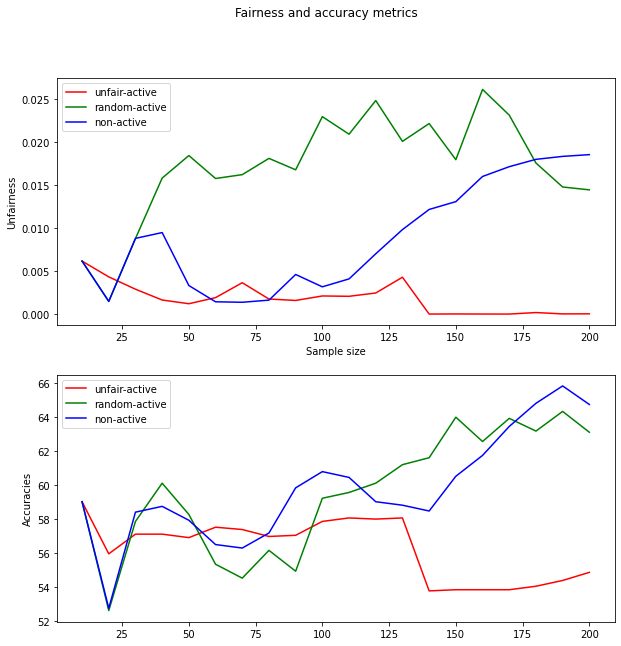

No handles with labels found to put in legend.


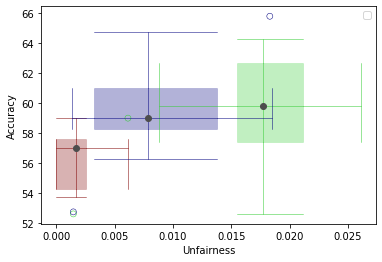

Ratio of e_loss/f_loss is 0.1 / 0.9
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
--------------------------------


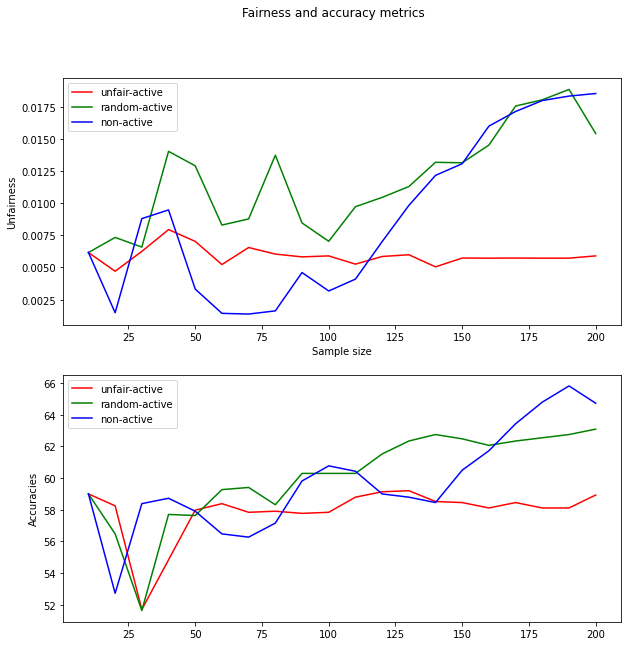

No handles with labels found to put in legend.


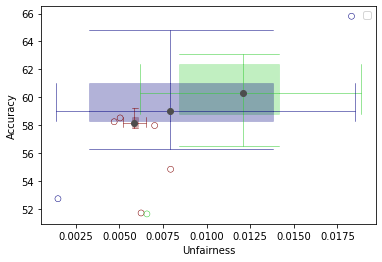

Ratio of e_loss/f_loss is 0.2 / 0.8
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
--------------------------------


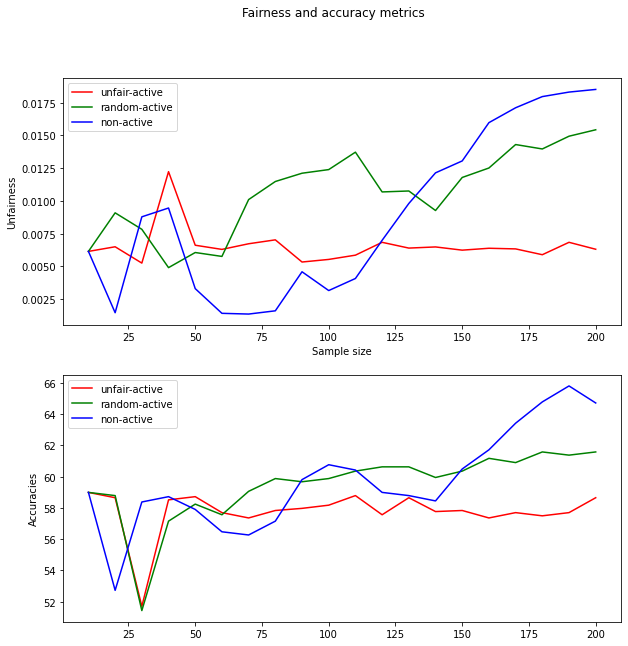

No handles with labels found to put in legend.


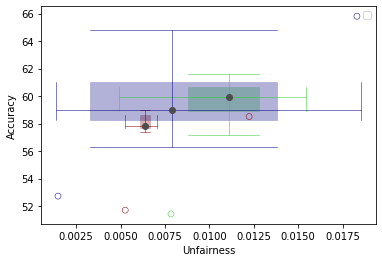

Ratio of e_loss/f_loss is 0.3 / 0.7
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
--------------------------------


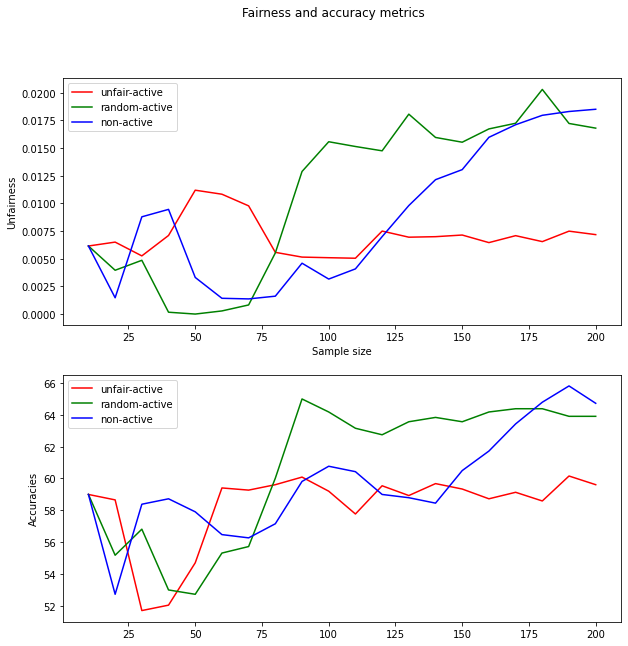

No handles with labels found to put in legend.


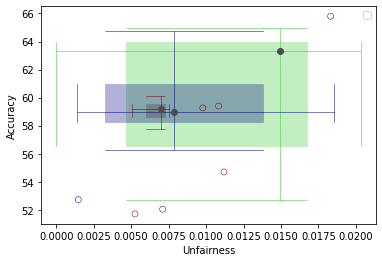

Ratio of e_loss/f_loss is 0.4 / 0.6
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
--------------------------------


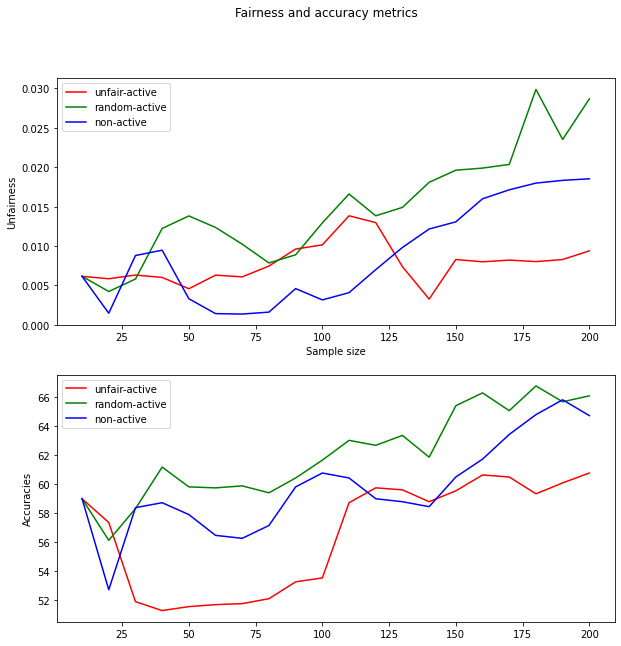

No handles with labels found to put in legend.


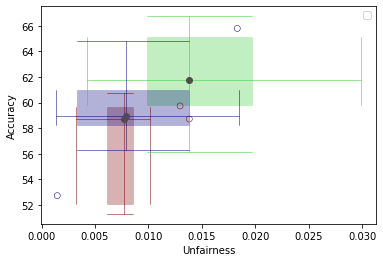

Ratio of e_loss/f_loss is 0.5 / 0.5
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
--------------------------------


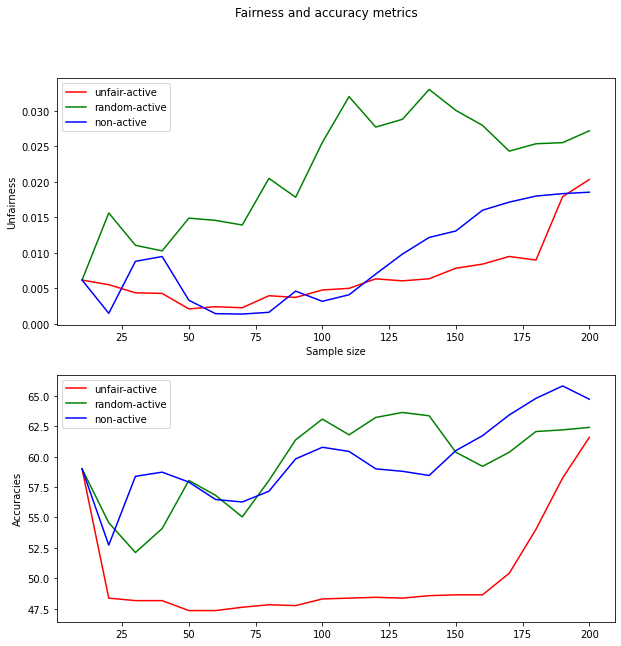

No handles with labels found to put in legend.


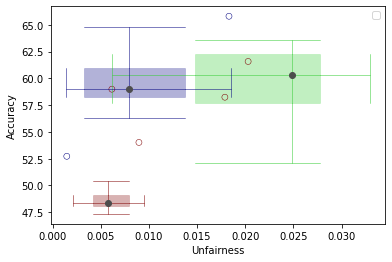

Ratio of e_loss/f_loss is 0.6 / 0.4
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
--------------------------------


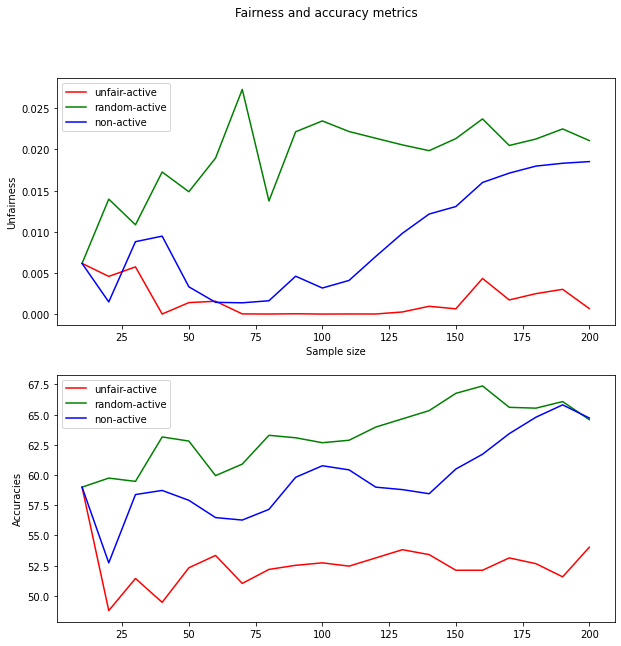

No handles with labels found to put in legend.


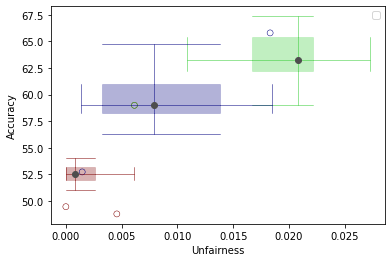

Ratio of e_loss/f_loss is 0.7 / 0.30000000000000004
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
-----------------

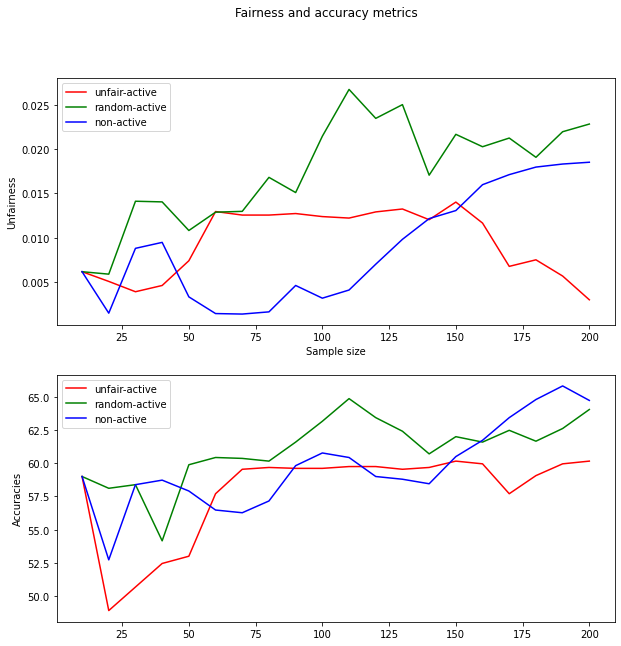

No handles with labels found to put in legend.


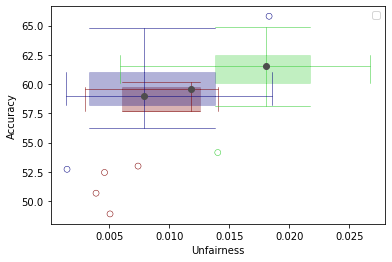

Ratio of e_loss/f_loss is 0.8 / 0.19999999999999996
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
-----------------

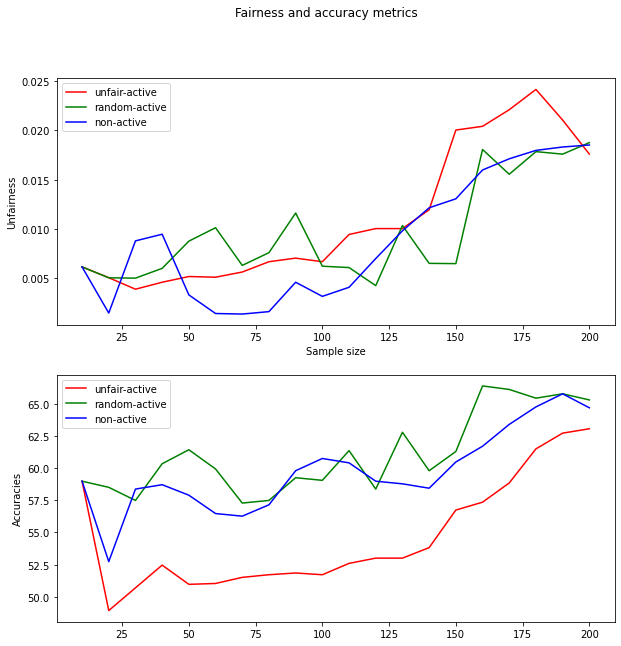

No handles with labels found to put in legend.


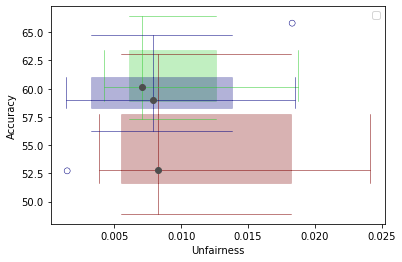

Ratio of e_loss/f_loss is 0.9 / 0.09999999999999998
--------------------------------
Iteration: 1
--------------------------------
Iteration: 2
--------------------------------
Iteration: 3
--------------------------------
Iteration: 4
--------------------------------
Iteration: 5
--------------------------------
Iteration: 6
--------------------------------
Iteration: 7
--------------------------------
Iteration: 8
--------------------------------
Iteration: 9
--------------------------------
Iteration: 10
--------------------------------
Iteration: 11
--------------------------------
Iteration: 12
--------------------------------
Iteration: 13
--------------------------------
Iteration: 14
--------------------------------
Iteration: 15
--------------------------------
Iteration: 16
--------------------------------
Iteration: 17
--------------------------------
Iteration: 18
--------------------------------
Iteration: 19
--------------------------------
Iteration: 20
-----------------

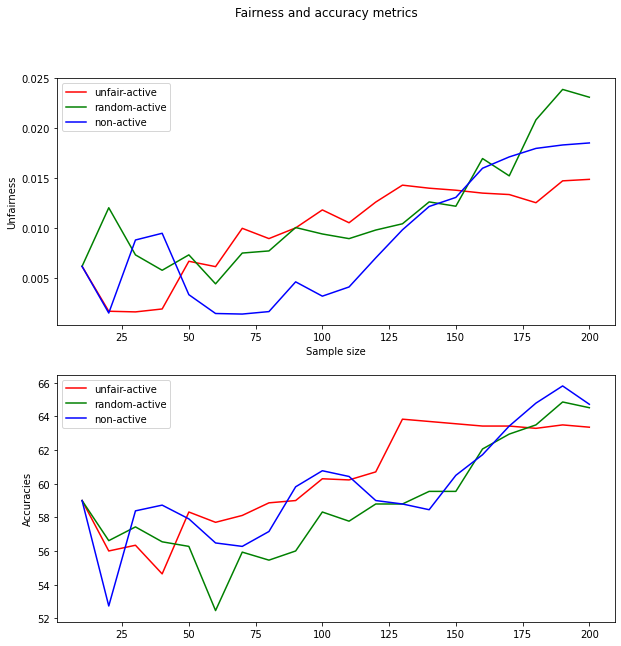

No handles with labels found to put in legend.


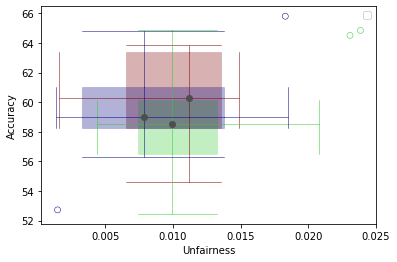

In [110]:
experiment(LogModel,200,10,"mutual_information","No_filter")